In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import libs.readhdf5

 readhdf5 version 2.4


In [2]:
r = libs.readhdf5.ReadHDF5()
r.ReadHDF5('../data/run045pn_b64-1.hdf5')
r.OpenHDF5()

Checking mat2hdf version...
mat2hdf version not match.


# time constant calculation
```引数：all pulse, all noise, low level (ex. 0.2), high level(ex. 0.8)```


In [3]:
def calc_tau(pulses, noises, low_lvl, high_lvl):
    tau          = []
    pulseheight  = []
    baseline     = []
    time         = r.time * 1e3 # msec
    all_eventnum = pulses.shape[0]

    for eventnum in range(all_eventnum):
        pulse      = pulses[eventnum]
        noise      = noises[eventnum]

        bsl        = np.mean(noise)
        pmax       = np.min(pulse)
        pmax_index = np.argmin(pulse)
        ph         = bsl - pmax

        low_line   = bsl - low_lvl * ph
        high_line  = bsl - high_lvl * ph

        one_tau = []
        for i in range(2):
            if i == 0:
                half_time  = time[:pmax_index]
                half_pulse = pulse[:pmax_index]
            else:
                half_time  = time[pmax_index:]
                half_pulse = pulse[pmax_index:]

            sliced_time = half_time[(half_pulse < low_line) & (half_pulse > high_line)]

            if sliced_time.size < 2:
                one_tau.append(time[1]-time[0])
            else:
                one_tau.append(sliced_time[-1]-sliced_time[0])


        tau.append(one_tau)
        pulseheight.append(ph)
        baseline.append(bsl)

    tau_array         = np.array(tau).reshape([-1,2])
    rise_array        = tau_array[:,0]
    fall_array        = tau_array[:,1]
    pulseheight_array = np.array(pulseheight)
    baseline_array    = np.array(baseline)

    return rise_array, fall_array, pulseheight_array, baseline_array

In [4]:
noise = r.noise * r.vres * 1e3 # mV
pulse = r.pulse * r.vres * 1e3 # mV
rise, fall, ph, bsl = calc_tau(pulse, noise, 0.2, 0.8)

# rise time distribution

1.5359998997155344


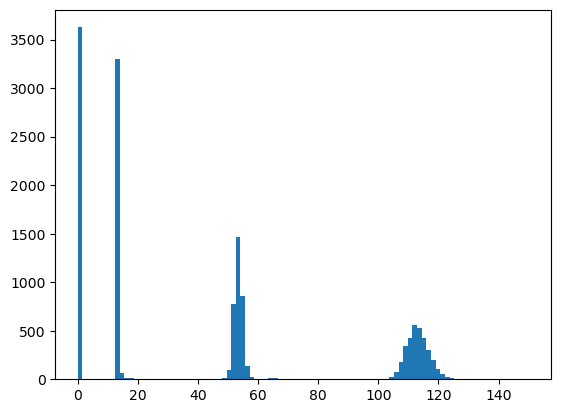

In [5]:
t_res = (r.time[1]-r.time[0]) * 1e6 # msec
print(t_res)
t_range = 150
b = (t_range/t_res).astype(int)

n, bins, patches = plt.hist(rise*1e3, bins=b, range=(0, t_range))

# histogramのx,yを準備
x = []
for i in range(b):
  x.append((bins[i]+bins[i+1])/2)

x = np.array(x)
y = n

In [6]:
def func(x, *params):

    #paramsの長さでフィッティングする関数の数を判別。
    num_func = int(len(params)/3)

    #ガウス関数にそれぞれのパラメータを挿入してy_listに追加。
    y_list = []
    for i in range(num_func):
        y = np.zeros_like(x)
        param_range = list(range(3*i,3*(i+1),1))
        amp = params[int(param_range[0])]
        ctr = params[int(param_range[1])]
        wid = params[int(param_range[2])]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
        y_list.append(y)

    #y_listに入っているすべてのガウス関数を重ね合わせる。
    y_sum = np.zeros_like(x)
    for i in y_list:
        y_sum = y_sum + i

    #最後にバックグラウンドを追加。
    y_sum = y_sum + params[-1]

    return y_sum

def fit_plot(x, *params):
    num_func = int(len(params)/3)
    y_list = []
    for i in range(num_func):
        y = np.zeros_like(x)
        param_range = list(range(3*i,3*(i+1),1))
        amp = params[int(param_range[0])]
        ctr = params[int(param_range[1])]
        wid = params[int(param_range[2])]
        y = y + amp * np.exp( -((x - ctr)/wid)**2) + params[-1]
        y_list.append(y)
    return y_list


In [7]:
# [amp, ctr, wid]
guess = []
guess.append([4000, 1, 1])
guess.append([3000, 15, 10])
guess.append([1500, 55, 15])
guess.append([500, 120, 20])

# backgroundの初期値
background = 0

#初期値リストの結合
guess_total = []
for i in guess:
    guess_total.extend(i)
guess_total.append(background)


[0][0][3632.342544822846]
[0][1][0.7564762739943557]
[0][2][0.363015715860164]
[1][0][3525.849143614434]
[1][1][13.319893910827485]
[1][2][0.6787064254190032]
[2][0][1471.3316404184627]
[2][1][53.421777587607295]
[2][2][1.989808918281045]
[3][0][541.3439322754243]
[3][1][112.88191221611407]
[3][2][5.2079010218673725]
[4][0][2.3541797337899646]


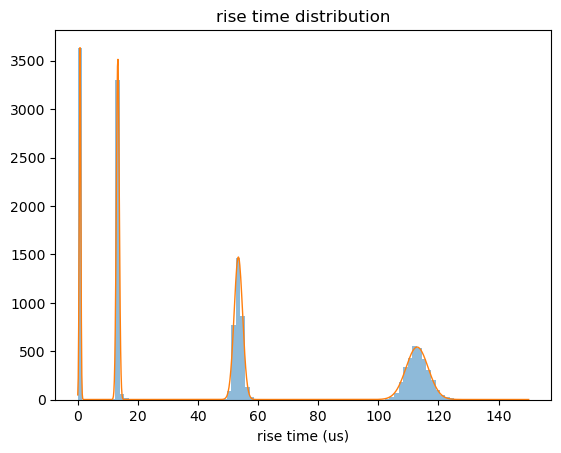

In [8]:
from scipy.optimize import curve_fit
import matplotlib.cm as cm
popt, pcov = curve_fit(func, x, y, p0=guess_total)

plt.hist(rise*1e3, bins=b, range=(0, t_range), alpha=0.5)
xx = np.linspace(0, 150, 1000)
plt.plot(xx, func(xx, *popt), lw=1, )
plt.title('rise time distribution')
plt.xlabel('rise time (us)')

# y_list = fit_plot(xx, *popt)
# baseline = np.zeros_like(xx) + popt[-1]
# for n,i in enumerate(y_list):
#     plt.fill_between(xx, i, baseline, facecolor=cm.rainbow(n/len(y_list)), alpha=0.6)

for i, key in enumerate(popt):
  row = i // 3
  col = i % 3
  print(f'[{row}][{col}][{key}]')

eventnum=2
fit parameters:
rise     : 13.64 +- 0.09292 us
fall1    : 174.3 +- 2.536 us
fall2    : 482.1 +- 9.512 us
const1   : 495.4 +- 7.373
const2   : 190.2 +- 8.474
bias     : 0.6479 +- 0.06738
 


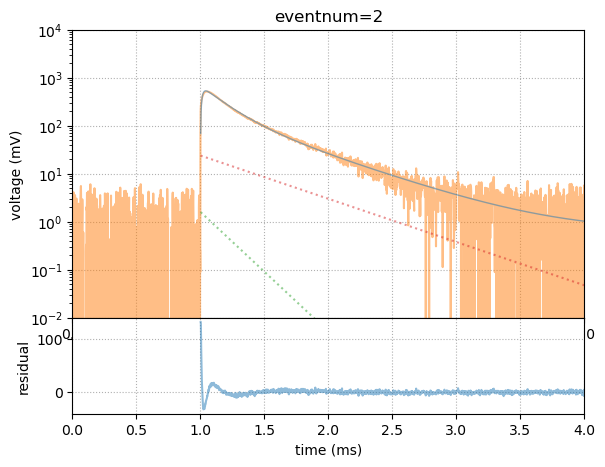

In [10]:
common = 2

p0 = [1.5e-3, 400e-3, 150e-3, 1e2, 0.1, 1]

p1 = (np.mean(r.noise[common]) - r.pulse[common])*r.vres*1e3
t = r.time*1e3

start = np.min(t[p1>10])
mask = t>start
tt = t[mask]-start
pp1 = p1[mask]

def pulse_func(x, *params):
    rise = params[0]
    fall1 = params[1]
    fall2 = params[2]
    con1 = params[3]
    con2 = params[4]
    bias = params[5]
    return con1*np.exp(-x/fall1)+con2*np.exp(-x/fall2)-(con1+con2)*np.exp(-x/rise)+bias

popt1, pcov1 = curve_fit(pulse_func, tt, pp1, p0=p0, maxfev=2000)
perr1 = np.sqrt(np.diag(pcov1))

fig = plt.figure()
ax1 = plt.axes([0.1, 0.3, 0.8, 0.6])
ax2 = plt.axes([0.1, 0.1, 0.8, 0.2], sharex=ax1)

ax1.plot(t, p1, alpha=0.5, c='tab:orange')
ax1.plot(t[mask], pulse_func(tt, *popt1), c='tab:blue', alpha=0.5, lw=1)
ax1.plot(t[mask], popt1[3]*np.exp(-t[mask]/popt1[1]), alpha=0.5, ls=':', c='tab:green')
ax1.plot(t[mask], popt1[4]*np.exp(-t[mask]/popt1[2]), alpha=0.5, ls=':', c='tab:red')
# ax1.plot(tt+start, -(popt1[3]+popt1[4])*np.exp(-(tt+start)/popt1[0]), alpha=0.5, ls=':', c='tab:cyan')
ax1.grid(linestyle='dotted')
ax1.set_yscale('log')
ax1.set_ylabel('voltage (mV)')
ax1.set_title(f'eventnum={common}')
ax1.set_xlim(0, 4)
ax1.set_ylim(1e-2, 1e4)

resi = pp1 - pulse_func(tt, *popt1)
ax2.plot(t[mask], resi, alpha=0.5, c='tab:blue')
ax2.grid(linestyle='dotted')
ax2.set_ylabel('residual')
ax2.set_xlabel('time (ms)')

print(f'eventnum={common}')
print(f'fit parameters:')
print(f'rise     : {popt1[0]*1e3 :.04} +- {perr1[0]*1e3 :.04} us')
print(f'fall1    : {popt1[1]*1e3 :.04} +- {perr1[1]*1e3 :.04} us')
print(f'fall2    : {popt1[2]*1e3 :.04} +- {perr1[2]*1e3 :.04} us')
print(f'const1   : {popt1[3] :.04} +- {perr1[3] :.04}')
print(f'const2   : {popt1[4] :.04} +- {perr1[4] :.04}')
print(f'bias     : {popt1[5] :.04} +- {perr1[5] :.04}')
print(f' ')


# smoothing

/tmp/ipykernel_30625/1608221236.py:6: RuntimeWarning: invalid value encountered in log10
  ori = np.log10((np.mean(r.noise[eventnum]) - r.pulse[eventnum])*r.vres*1e3)


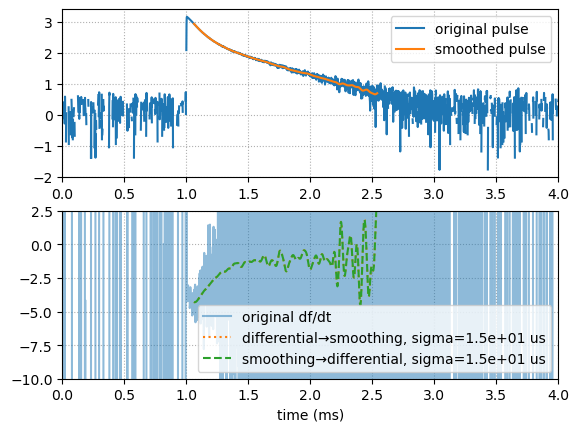

In [11]:
from scipy.ndimage import gaussian_filter1d
eventnum = 1
sig = 10

dt = t[1]-t[0]
ori = np.log10((np.mean(r.noise[eventnum]) - r.pulse[eventnum])*r.vres*1e3)


def differential(f):
    dfdt = []
    datanum = t.shape[0]
    for i in range(datanum-1):
        dif = f[i+1] - f[i]
        dfdt.append(dif/dt)

    dfdt.append(0)
    return dfdt


# differential → smoothing
dori = differential(ori)
dsmooth = gaussian_filter1d(dori, sig)

# smoothing　→ differential
smo = gaussian_filter1d(ori, sig)
smoothd = differential(smo)


fig, ax = plt.subplots(2, 1)
ax[0].plot(t, ori, label='original pulse')
ax[0].plot(t, smo, label='smoothed pulse')
ax[0].set_xlim(0, 4)
ax[0].grid(linestyle='dotted')
ax[0].legend()

ax[1].plot(t, dori, alpha=0.5, label='original df/dt')
ax[1].plot(t, dsmooth, ':', label=f'differential→smoothing, sigma={sig*dt*1e3 :.2} us')
ax[1].plot(t, smoothd, '--', label=f'smoothing→differential, sigma={sig*dt*1e3 :.2} us')
ax[1].set_xlim(0, 4)
ax[1].set_xlabel('time (ms)')
ax[1].set_ylim(-10, 2.5)
ax[1].grid(linestyle='dotted')
ax[1].legend()

nyquist = 325.52085458638345 kHz


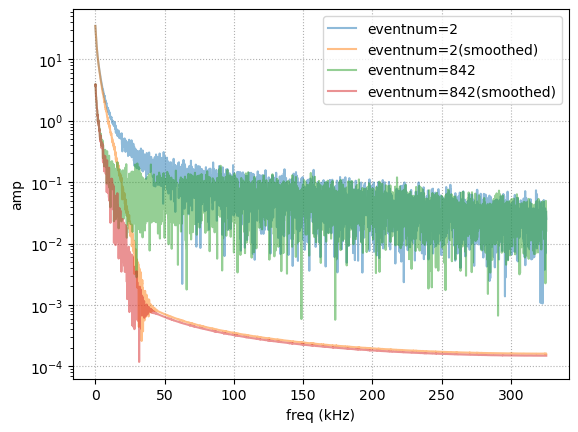

In [12]:
from scipy.fft import fft, fftfreq

events = [2, 842]

for eventnum in events:
    y = (np.mean(r.noise[eventnum]) - r.pulse[eventnum])*r.vres*1e3
    smo = gaussian_filter1d(y, sig)

    # サンプル数
    N = len(y)
    # フーリエ変換する
    yf = fft(y)
    smof = fft(smo)
    # サンプリング周期
    T = r.time[1]-r.time[0]
    # 周波数軸の作成
    tf = fftfreq(N, T)[:N//2]


    plt.plot(tf/1e3, 2.0/N * np.abs(yf[0:N//2]), alpha=0.5, label=f'eventnum={eventnum}')
    plt.plot(tf/1e3, 2.0/N * np.abs(smof[0:N//2]), alpha=0.5, label=f'eventnum={eventnum}(smoothed)')

# ナイキスト周波数
nyquist = 1/T/2
print(f'nyquist = {nyquist/1e3} kHz')

plt.yscale('log')
plt.xlabel('freq (kHz)')
plt.ylabel('amp')
plt.grid(linestyle='dotted')
plt.legend()


In [13]:
noises = r.noise * r.vres * 1e3 # mV
pulses = r.pulse * r.vres * 1e3 # mV
sig = 10

s_pulses = []
for eventnum in range(pulses.shape[0]):
    pulse = pulses[eventnum]
    s_pulse = gaussian_filter1d(pulse, sig)
    s_pulses.append(s_pulse)

s_pulses = np.array(s_pulses)   
s_rise, s_fall, s_ph, s_bsl = calc_tau(s_pulses, noises, 0.2, 0.8)

1.5359998997155344


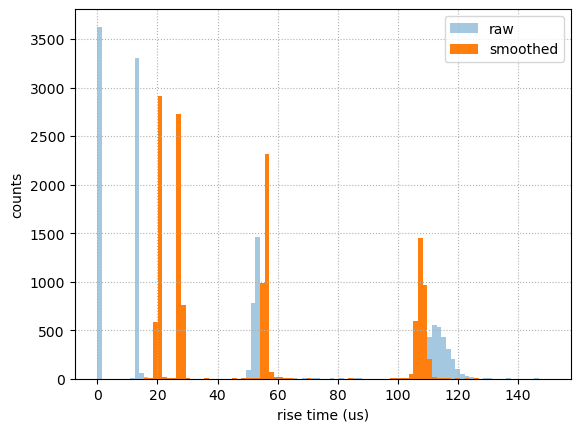

In [31]:
t_res = (r.time[1]-r.time[0]) * 1e6 # msec
print(t_res)
# t_range = 800
t_range = 150
b = (t_range/t_res).astype(int)

plt.hist(rise*1e3, bins=b, range=(0, t_range), alpha=0.4, label='raw')
n, bins, patches = plt.hist(s_rise*1e3, bins=b, range=(0, t_range), label='smoothed')
plt.xlabel('rise time (us)')
plt.ylabel('counts')
plt.grid(linestyle='dotted')
plt.legend()

x = []
for i in range(b):
  x.append((bins[i]+bins[i+1])/2)

x = np.array(x)
y = n

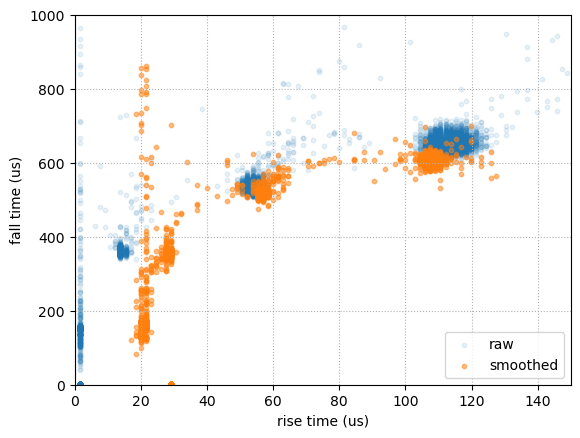

In [29]:
plt.scatter(rise   * 1e3, fall   * 1e3, alpha=0.1, s=10, label='raw')
plt.scatter(s_rise * 1e3, s_fall * 1e3, alpha=0.5, s=10, label='smoothed')
plt.xlim(0,150)
plt.ylim(0,1000)
plt.xlabel('rise time (us)')
plt.ylabel('fall time (us)')
plt.grid(linestyle='dotted')
plt.legend()

In [16]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()    # <- Notebook出力にはこの１行が必要

scatter = go.Scatter3d(
    x=s_rise*1e3,
    y=s_fall*1e3,
    z=s_ph,
    mode='markers',
    marker=dict(
        size=1
    )
)
fig = go.Figure(data=scatter)
fig.update_layout(
    scene = dict(
        xaxis = dict(range=[0,150], title='rise time (us)'),
        yaxis = dict(range=[0,1000], title='fall time (us)'),
        zaxis = dict(title='pulse height (a.u.)')
    )
)
iplot(fig)    # <- Notebookに出力するにはiplot関数を使う
